In [79]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

# Save the model and tokenizer to a directory
save_directory = "./saved_model"  # Path where you want to save the model

# Save the model weights, config, and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\tokenizer.json')

In [1]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

# Path to your saved model directory
model_directory = r'C:\Users\hyoil\Desktop\project2\saved_model'

# Load the model and tokenizer from the local directory
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_directory,
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained(model_directory)

print(model)

c:\Users\hyoil\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

class CustomDataset(Dataset):
    def __init__(self, encoded_data, block_size=128):
        self.data = encoded_data.squeeze()  # Ensure 1D tensor
        self.block_size = block_size

    def __len__(self):
        return max(1, (len(self.data) - self.block_size) // self.block_size)

    def __getitem__(self, idx):
        start_idx = idx * self.block_size
        input_seq = self.data[start_idx:start_idx + self.block_size]
        target_seq = self.data[start_idx + 1:start_idx + self.block_size + 1]
        return input_seq, target_seq

# Load model and tokenizer
model_directory = r'C:\Users\hyoil\Desktop\project2\saved_model'
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForCausalLM.from_pretrained(model_directory)

# Freeze all layers except the last two MLP layers
for name, param in model.named_parameters():
    if 'wte' not in name:
        param.requires_grad = False
    else:
        print(name, param.shape)
        param.requires_grad = True

# Check which layers are frozen
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.requires_grad}")


# Read and encode data
with open("LunaDiary-2024.12.02 PM 11_55 (2).txt", "r") as file:
    content = file.read()

enc_data = tokenizer.encode(content, return_tensors='pt')

# Setup device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.train()  # Set to training mode

dataset = CustomDataset(enc_data)  # Ensure enc_data is compatible with your CustomDataset

# Split dataset into train and validation sets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop
epochs = 0

transformer.wte.weight torch.Size([51200, 768])
transformer.wte.weight: True


In [3]:
# Add dropout if not already in model
model.config.dropout = 0.1  # Moderate dropout

# Gradient clipping to prevent exploding gradients
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(0.)

In [21]:
import matplotlib.pyplot as plt

single_run = 10

epochs += single_run

model = model.to(device)
for epoch in range(single_run):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs, labels=targets)
        loss = outputs.loss
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)}, Training Loss: {loss.item()}")
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss}")
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs, labels=targets)
            loss = outputs.loss
            
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss}")

Batch 0/341, Training Loss: 6.9045538902282715
Batch 200/341, Training Loss: 6.206752777099609
Epoch 1, Average Training Loss: 6.623169791313909
Epoch 1, Average Validation Loss: 7.175290235253268
Batch 0/341, Training Loss: 5.730604648590088
Batch 200/341, Training Loss: 6.287274360656738
Epoch 2, Average Training Loss: 6.414636093150835
Epoch 2, Average Validation Loss: 7.076745304950448
Batch 0/341, Training Loss: 6.120959281921387
Batch 200/341, Training Loss: 6.4039835929870605
Epoch 3, Average Training Loss: 6.240010475483109
Epoch 3, Average Validation Loss: 7.003000081971634
Batch 0/341, Training Loss: 6.26254940032959
Batch 200/341, Training Loss: 5.85254430770874
Epoch 4, Average Training Loss: 6.082653820339885
Epoch 4, Average Validation Loss: 6.949003890503285
Batch 0/341, Training Loss: 6.145957946777344
Batch 200/341, Training Loss: 5.917186260223389
Epoch 5, Average Training Loss: 5.937101341762151
Epoch 5, Average Validation Loss: 6.90647041520407
Batch 0/341, Training

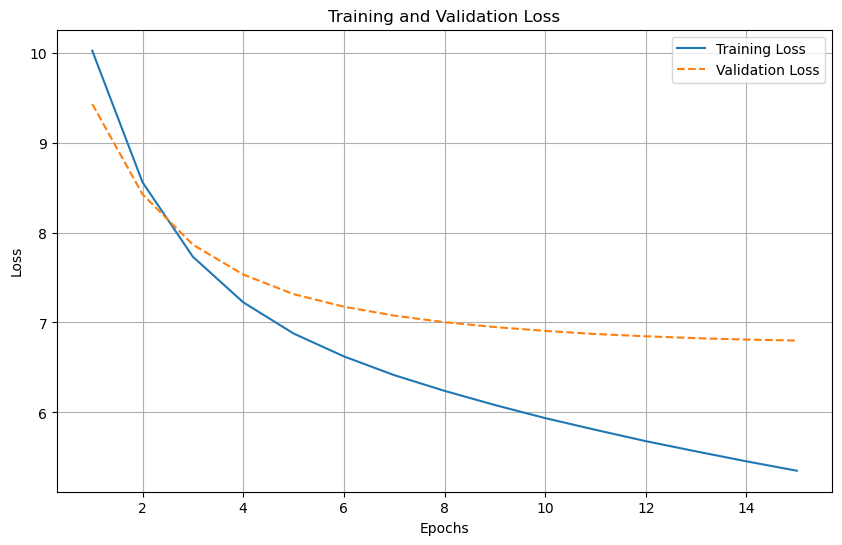

In [22]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [25]:

#model = GPT2LMHeadModel.from_pretrained(model_directory)
text = '나의 인생 목표는'
input_ids = tokenizer.encode(text, return_tensors='pt')
model = model.to('cpu')
gen_ids = model.generate(input_ids,
                           max_length=8,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

나의 인생 목표는 성공이다.
19.0
